In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# input data

## defining the dips position
G_1 = np.array([[6,8],[11,8],[19,7],[18,6],[14,4],[1,3],[3,2],[14,1]])

G_1_o = np.array([[1,1.7],[-1,2],[1,1],[1,1],[-1,1.2],[1,0.5],[1,0.5],[-1,1]])

## defining interface data
layer1 = np.array([[2,4],[15,2]])
layer2 = np.array([[2,9],[10,7],[18,8]])

## deining range
a_T = 15

## defining control points
con_p = np.array([[1,5],[5,7],[10,5]])

print(con_p[0,0])

1


In [3]:
def squared_euclidean_distance(x_1,x_2):
    sqd = np.sqrt(np.reshape(np.sum(x_1**2,1),newshape =(x_1.shape[0],1))+\
    np.reshape(np.sum(x_2**2,1),newshape =(1,x_2.shape[0]))-\
    2*(x_1@x_2.T))
    return sqd

def cartesian_dist(x_1,x_2):
    return np.concatenate([
        np.tile(x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        np.tile(x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 

def cov_gradients(dist_tiled):
    
    condition1 = 0
    a = (h_u*h_v)
    b = dist_tiled**2

    t1 =  np.divide(a, b, out=np.zeros_like(a),casting='unsafe', where=b!=0)
    t2 = np.where(dist_tiled < a_T,(-c_o_T*((-14/a_T**2)+
                 105/4*dist_tiled/a_T**3 -
                 35/2 * dist_tiled**3 / a_T **5 +
                 21 /4 * dist_tiled**5/a_T**7)),0)+\
          np.where(dist_tiled < a_T,(c_o_T * 7 * (9 * dist_tiled ** 5 -
                      20 * a_T ** 2 * dist_tiled ** 3 +
                      15 * a_T ** 4 * dist_tiled -
                      4 * a_T ** 5) / (2 * a_T ** 7)),0)

    # when we do the covariance of Gx with Gx, Gy with Gy and so on, quation B9 in Gempy paper
    t3 = perpendicularity_matrix * \
          np.where(dist_tiled < a_T,(c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                   21 / 4 * dist_tiled ** 5 / a_T ** 7)),0)
    t4 = 1/3*np.eye(dist_tiled.shape[0])

    condition2 = t1 * t2 - t3 + t4

    C_G = np.where(dist_tiled==0, condition1, condition2) ## adding nugget effect
    return C_G

def set_rest_ref_matrix(number_of_points_per_surface):
    ref_layer_points = np.repeat(np.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = np.concatenate([layer1[0:-1],layer2[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*(\
                (np.where(sed_rest_rest < a_T, (1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7),0)) -\
                (np.where(sed_ref_rest < a_T, (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7),0)) -\
                (np.where(sed_rest_ref < a_T, (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7),0)) +\
                 (np.where(sed_ref_ref < a_T, (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7),0)))
    
    return C_I

def cartesian_dist_no_tile(x_1,x_2):
    return np.concatenate([
        np.transpose((x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]))),
        np.transpose((x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = hu_rest*np.where(sed_dips_rest < a_T,(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7)),0)-\
    hu_ref*np.where(sed_dips_ref < a_T,(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)),0)
    return C_GI

def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)

def perpendicularity(G_1):
    a = np.concatenate([np.ones([G_1.shape[0],G_1.shape[0]]),np.zeros([G_1.shape[0],G_1.shape[0]])],axis = 1)
    b = np.concatenate([np.zeros([G_1.shape[0],G_1.shape[0]]),np.ones([G_1.shape[0],G_1.shape[0]])],axis = 1)

    return np.concatenate([a,b],axis = 0)    

def get_coef(con_p):
    """
    Convert quadratic Bézier curve to quadratic polynomials

    Args:
        x1, x2, x3: x coodinates of control points
        y1, y2, y3: y coodinates of control points
        
    Returns:
        a, b, c, d, e: coefficient of quadratic polynomials
    """
    x1 = con_p[0,0]
    x2 = con_p[1,0]
    x3 = con_p[2,0]
    y1 = con_p[0,1]
    y2 = con_p[1,1]
    y3 = con_p[2,1]

    a = 2*x1*y1*y3 - 4*x1*y2**2 + 4*x1*y2*y3 -2*x1*y3**2 + 4*x2*y1*y2 - \
        8*x2*y1*y3 + 4*x2*y2*y3 - 2*x3*y1**2 + 4*x3*y1*y2 + 2*x3*y1*y3 - 4*x3*y2**2 
    b = -2*x1**2*y3 + 4*x1*x2*y2 + 4*x1*x2*y3 + 2*x1*x3*y1 - 8*x1*x3*y2 + \
        2*x1*x3*y3 - 4*x2**2*y1 - 4*x2**2*y3 + 4*x2*x3*y1 + 4*x2*x3*y2 - 2*x3**2*y1
    c = y1**2 - 4*y1*y2 + 2*y1*y3 + 4*y2**2 - 4*y2*y3 + y3**2
    d = x1**2 - 4*x1*x2 + 2*x1*x3 + 4*x2**2 - 4*x2*x3 + x3**2
    e = -2*x1*y1 + 4*x1*y2 - 2*x1*y3 + 4*x2*y1 - 8*x2*y2 +4*x2*y3 - 2*x3*y1 + 4*x3*y2 - 2*x3*y3

    return a,b,c,d,e



E:\python\envs\gempy\lib\site-packages\ipykernel_launcher.py:86: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


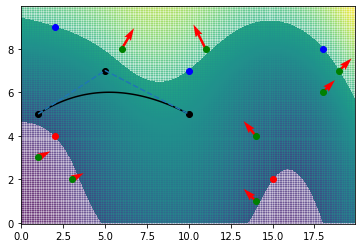

In [4]:
c_o_T = a_T**2/14/3

G_1_tiled = np.tile(G_1,[2,1])

h_u = cartesian_dist(G_1,G_1)
h_v = h_u.T

perpendicularity_matrix = perpendicularity(G_1)

dist_tiled = squared_euclidean_distance(G_1_tiled,G_1_tiled)

dist_tiled = dist_tiled + np.eye(dist_tiled.shape[0])

C_G = cov_gradients(dist_tiled)

number_of_layer = 2

number_of_points_per_surface = np.array([layer1.shape[0],layer2.shape[0]])

ref_layer_points,rest_layer_points = set_rest_ref_matrix(number_of_points_per_surface)

sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

C_I = cov_interface(ref_layer_points,rest_layer_points)

sed_dips_rest = squared_euclidean_distance(G_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(G_1_tiled,ref_layer_points)

hu_rest = cartesian_dist_no_tile(G_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(G_1,ref_layer_points)

C_GI = cov_interface_gradients(hu_rest,hu_ref)
C_IG = C_GI.T

xx = safe_arange(0,20,0.1)
yy = safe_arange(0,10,0.1)
XX,YY = np.meshgrid(xx,yy)
X = (np.reshape(XX,[-1])).T
Y = (np.reshape(YY,[-1])).T

grid = np.stack([X,Y],axis = 1)

hu_Simpoints = cartesian_dist_no_tile(G_1,grid)
sed_dips_SimPoint = squared_euclidean_distance(G_1_tiled,grid)
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)


K = np.concatenate([np.concatenate([C_G,C_GI],axis = 1),np.concatenate([C_IG,C_I],axis = 1)],axis = 0)

# convert quadratic Bézier curve to quadratic polynomials
cof_x, cof_y, cof_xx, cof_yy, cof_xy = get_coef(con_p)


# define the partial derivative of drift to x
D_X = ( cof_x * 1 + cof_xx * 2 * G_1[:,0] + cof_xy * G_1[:,1]).reshape(G_1.shape[0],1)

# define the partial derivative of drift to y
D_Y = ( cof_y * 1 + cof_yy * 2 * G_1[:,1] + cof_xy * G_1[:,0]).reshape(G_1.shape[0],1)

# define the interface points contribution to drift
D_I = ( cof_x*ref_layer_points[:,0] + cof_y*ref_layer_points[:,1] + cof_xx*ref_layer_points[:,0]**2 + \
        cof_yy*ref_layer_points[:,1]**2 + cof_xy * ref_layer_points[:,0] * ref_layer_points[:,1] - \
        cof_x*rest_layer_points[:,0] - cof_y*rest_layer_points[:,1] - cof_xx*rest_layer_points[:,0]**2 - \
        cof_yy*rest_layer_points[:,1]**2 - cof_xy * rest_layer_points[:,0] * rest_layer_points[:,1])\
                                                                .reshape(rest_layer_points.shape[0],1)

# build the dirft matrix
D = np.vstack([D_X , D_Y , D_I])
D_T = D.T

# build zero matrix
zero_matrix = np.zeros([1,1])

# concatenate drift matrix and kriging matrix
K_D = np.concatenate([np.concatenate([K,D],axis = 1),np.concatenate([D_T,zero_matrix],axis = 1)],axis = 0)

# build right side matrix of cokriging system
bk = np.concatenate([G_1_o[:,0],G_1_o[:,1],np.zeros(K_D.shape[0]-G_1.shape[0]*2)],axis = 0)
bk = np.reshape(bk,newshape = [bk.shape[0],1])

# solve kriging weight
w = np.linalg.lstsq(K_D,bk)[0]

# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(sed_dips_SimPoint < a_T)*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 - 35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 + 21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = np.sum(sigma_0_grad,axis=0)
# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:-1]*(c_o_T  * ((sed_rest_SimPoint < a_T)*(1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
            35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
            7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
            3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
            (sed_ref_SimPoint < a_T)*(1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
            35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
            7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
            3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = np.sum(sigma_0_interf,axis = 0)

# 2nd order drift contribution
sigma_0_2nd_drift_1 = grid[:,0]* (w[-1]).T * cof_x

sigma_0_2nd_drift_2 = grid[:,1]* (w[-1]).T * cof_y

sigma_0_2nd_drift_3 = grid[:,0]**2 * (w[-1]).T * cof_xx

sigma_0_2nd_drift_4 = grid[:,1]**2 * (w[-1]).T * cof_yy

sigma_0_2nd_drift_5 = grid[:,1] * grid[:,0] * (w[-1]).T * cof_xy




sigma_0_2nd_drift = sigma_0_2nd_drift_1 + sigma_0_2nd_drift_2 + sigma_0_2nd_drift_3 + sigma_0_2nd_drift_4 + sigma_0_2nd_drift_5


interpolate_result = sigma_0_grad+sigma_0_interf+sigma_0_2nd_drift

intp = np.reshape(interpolate_result,[100,200]) # reshape the result to matrix shape

#plt.contour(XX,YY,intp,50)

layer_lvl=np.concatenate([intp[np.where((XX==layer1[0,0])&(YY==layer1[0,1]))],intp[np.where((XX==layer2[0,0])&(YY==layer2[0,1]))]])

plt.contourf(XX,YY,intp,levels=layer_lvl)
plt.pcolor(XX,YY,intp, alpha=0.3, shading='auto')

#plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[:,0], G_1[:,1], 'go')


plt.quiver([G_1[:,0]],[G_1[:,1]],G_1_o[:,0],G_1_o[:,1],color='r')


mm=np.array([])
nn=np.array([])
for t in np.arange(0,1,0.01):
    m = np.array([con_p[0,0]*t**2 + con_p[1,0]*t*(1-t)*2 + con_p[2,0]*(1-t)**2])
    n = np.array([con_p[0,1]*t**2 + con_p[1,1]*t*(1-t)*2 + con_p[2,1]*(1-t)**2])
    mm = np.append(mm,m)
    nn = np.append(nn,n)
plt.plot(mm,nn,color='k')

plt.plot(con_p[:,0],con_p[:,1],'ko')
plt.plot(con_p[:,0],con_p[:,1],'--')

In [6]:
print(number_of_points_per_surface)

[2 3]
